<a href="https://colab.research.google.com/github/mMaRuf1998/Extras/blob/main/WorkedLoaded_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import os
from keras.models import load_model
from scipy.interpolate import splev, splrep
from sklearn.metrics import confusion_matrix

base_dir = "/content/drive/MyDrive/apnea-ecg/1.0.0"

ir = 3
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))



In [ ]:
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "apnea-ecg2.pkl"), 'rb') as f:
        apnea_ecg = pickle.load(f)

    x_train = []
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_train[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_train.append([rri_interp_signal, ampl_interp_signal])
    x_train = np.array(x_train, dtype="float32").transpose((0, 2, 1))
    y_train = np.array(y_train, dtype="float32")

    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_test[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_test.append([rri_interp_signal, ampl_interp_signal])
    x_test = np.array(x_test, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return (x_train, y_train, groups_train), (x_test, y_test, groups_test)

In [ ]:
if __name__ == "__main__":
    (x_train, y_train, groups_train), (x_test, y_test, groups_test) = load_data()

    model = load_model("/content/drive/MyDrive/apnea-ecg/1.0.0/CNNmodel.final.h5")
    model.summary()

    print("training:")
    y_true, y_pred = y_train, np.argmax(model.predict(x_train, batch_size=1024, verbose=1), axis=-1)

    C = confusion_matrix(y_true, y_pred, labels=(1, 0))
    TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
    acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
    print("acc: {}, sn: {}, sp: {}".format(acc, sn, sp))

    print("testing:")
    y_true, y_pred = y_test, np.argmax(model.predict(x_test, batch_size=1024, verbose=1), axis=-1)

    C = confusion_matrix(y_true, y_pred, labels=(1, 0))
    TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
    acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
    print("acc: {}, sn: {}, sp: {}".format(acc, sn, sp))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 900, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 448, 32)           352       
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 73, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 24, 64)            0     

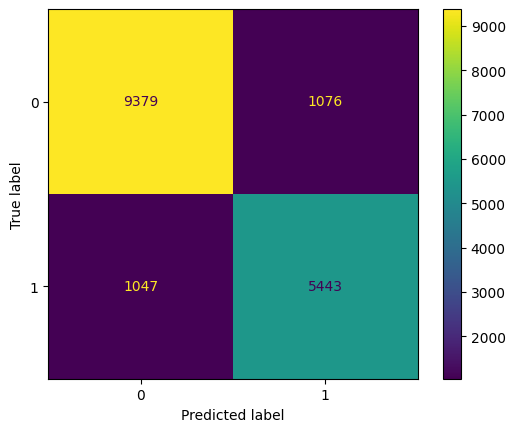

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=(0, 1))
disp.plot()



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     10455
         1.0       0.83      0.84      0.84      6490

    accuracy                           0.87     16945
   macro avg       0.87      0.87      0.87     16945
weighted avg       0.87      0.87      0.87     16945



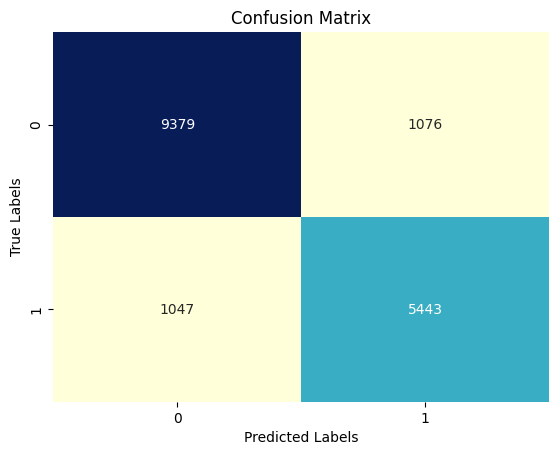

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("/content/drive/MyDrive/apnea-ecg/1.0.0/Confusion_matrix_leNet5.png",dpi=1200)
plt.show()


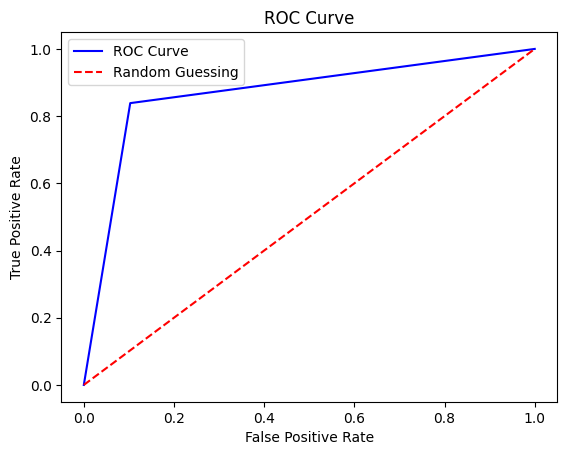

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefigure("/content/drive/MyDrive/apnea-ecg/1.0.0/Roc_Curve.png",dpi=1200))
plt.show()

AUC-ROC: 0.867878809985417


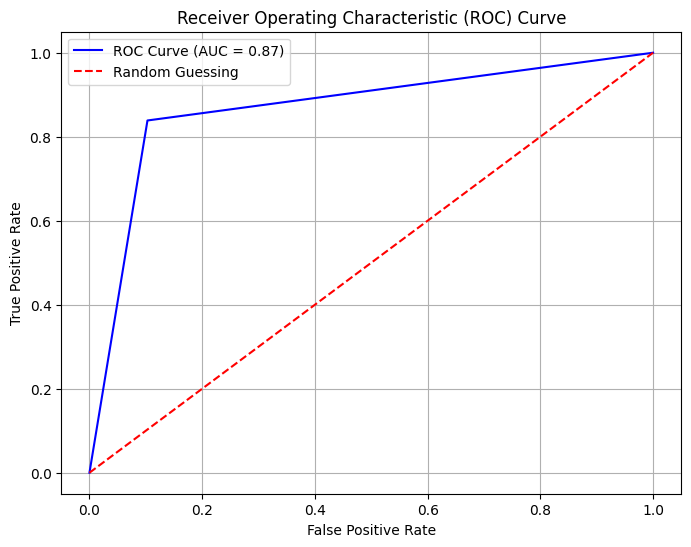

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assuming y_scores are the predicted probabilities for each instance
# y_true are the true labels

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred)
print("AUC-ROC:", auc_roc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/apnea-ecg/1.0.0/RocAuc_Curve1.png",dpi=1200)

plt.show()
